In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.power import tt_ind_solve_power
from scipy.stats import ttest_ind

In [10]:
sns.set_theme(context='notebook', 
                  style='darkgrid', 
                  palette='deep',
                  font='sans-serif', 
                  font_scale=1, 
                  color_codes=True, 
                  rc=None)

##  Зависимость ошибки второго рода от величины эффекта
$\mu$ и $std$ мы можно оценить по историческим данным,

$\alpha$ и $\beta$ — определяем сами

Смоделируем ситуации, когда ожидаемый и реальный эффект не совпадают, посмотрим, как будет меняться ошибка второго рода.

In [11]:
def check_ttest(a, b, alpha=0.05):
    _, pvalue = ttest_ind(a, b)
    return int(pvalue < alpha)

In [12]:
mu = 100
std = 50
alpha = 0.05
beta = 0.2
effect_size = 1.05
effect_sizes = np.linspace(1.01, 1.09, 9)

# standardized effect size, difference between the two means divided
# by the standard deviation. `effect_size` has to be positive.
standardized_effect_size = (effect_size - 1) * mu / std
sample_size = tt_ind_solve_power(effect_size=standardized_effect_size,
                                nobs1=None,
                                alpha=alpha,
                                power=1 - beta,
                                ratio=1.0,
                                alternative='two-sided')
sample_size = int(np.ceil(sample_size))

print(f'sample_size = {sample_size}')

sample_size = 1571


In [13]:
errors = []
for effect_size in effect_sizes:
    ab_results = []
    for _ in range(3000):
        a = np.random.normal(loc=mu,
                             scale=std,
                             size=sample_size)
        b = np.random.normal(loc=mu*effect_size,
                             scale=std,
                             size=sample_size )

        ab_results.append(check_ttest(a, b))
    errors.append(1 - np.mean(ab_results))

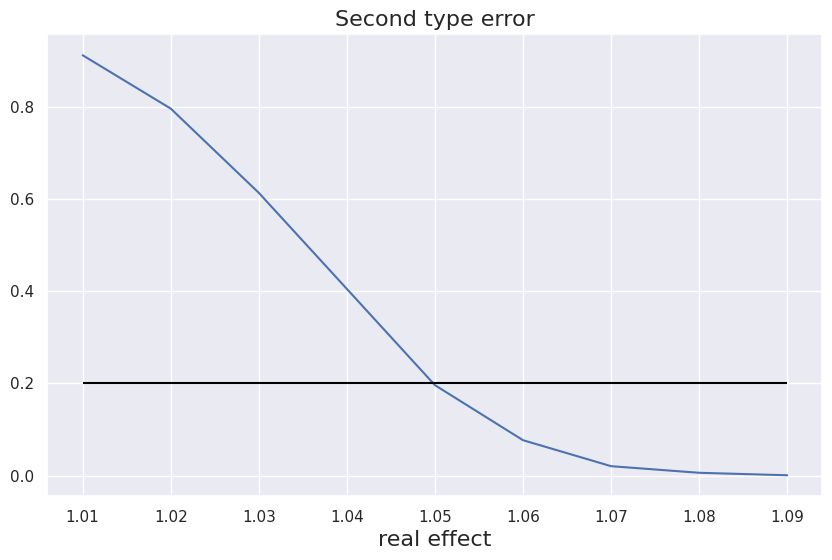

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(effect_sizes, errors)
plt.title('Second type error', fontsize=16)
plt.hlines(0.2, 1.01, 1.09, color ='black')
plt.xlabel('real effect', fontsize=16)
plt.show()

Для эффекта в 5% был посчитан размер выборки(sample_size), затем, используя этот размер выборки, моделируется ситуация с различнымы размерами эффекта.
Если дизайн эксперимента верен, при эффекте 5%  мощность теста соответствует 80%. В случае если мы ошиблись в эффекте на 1%, думали будет 5%, а оказалось 4%, то это увеличивает ошибку второго рода в два раза, с 20% до 40%.

Если есть возможность, лучше собирать данные с запасом.

### Контроль вероятности ошибки I рода
Необходимо убедиться, что если мы многократно запускаем А/А тесты, то $p-value$  имеет равномерное распределение

In [15]:
a_one = np.random.normal(loc=mu,
                     scale=std,
                     size=sample_size)
a_two = np.random.normal(loc=mu,
                     scale=std,
                     size=sample_size )

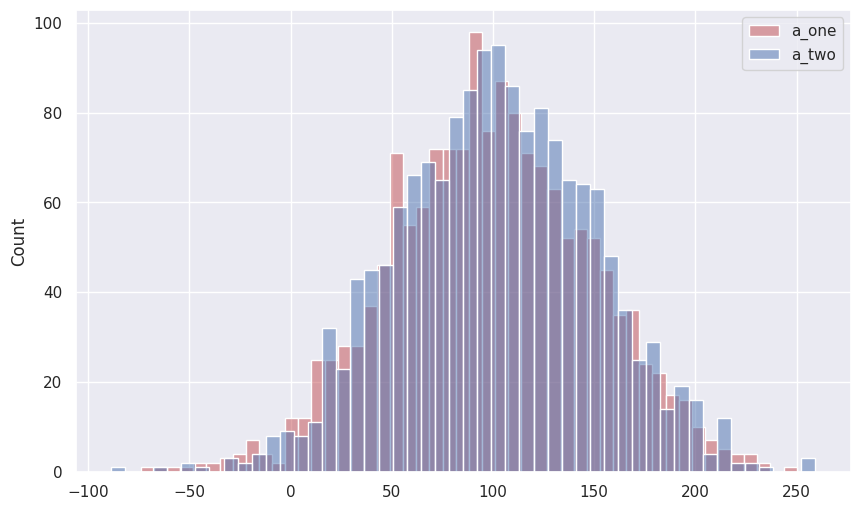

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(x=a_one, color="r", alpha=0.5, bins = 50)
sns.histplot(x=a_two, color="b", alpha=0.5, bins = 50)

plt.legend(labels=['a_one','a_two'])
plt.show()

In [17]:
p_values = []
for _ in range(1000):
    a_one = np.random.normal(loc=mu,
                         scale=std,
                         size=sample_size)
    a_two = np.random.normal(loc=mu,
                         scale=std,
                         size=sample_size )
    _, pvalue = ttest_ind(a_one, a_two)
    
    p_values.append(pvalue)

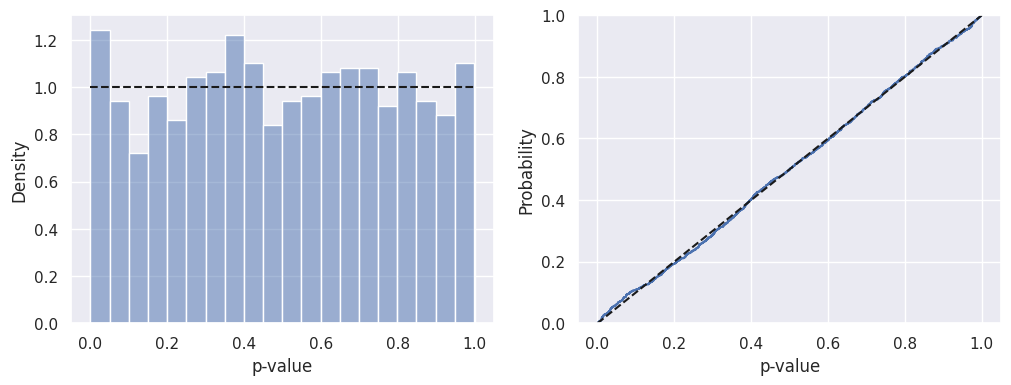

In [18]:
def plot_hist_and_ecdf(p_values, add_vline=False):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(p_values, ax=ax1, alpha=0.5, bins = 20, stat='density')
    ax1.plot([0, 1], [1, 1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    # empirical cumulative distribution functions
    sns.ecdfplot(p_values, ax=ax2, stat='proportion')
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    if add_vline:
        ax2.plot([0.05, 0.05], [0, 1], 'k-', alpha=0.5)   
        
plot_hist_and_ecdf(p_values)

При **отсутствии** эффекта мы должны контролировать вероятность ошибки 1-го рода, то есть
* на уровне значимости 0.0 мы должны ошибаться в среднем в 0 случаях из 100
(то есть всегда говорим, что отличий нет)
* на уровне значимости 0.05 мы должны ошибаться в среднем в 5 случаях из 100
* на уровне значимости 0.1 мы должны ошибаться в среднем в 10 случаях из 100
* на уровне значимости 0.2 мы должны ошибаться в среднем в 20 случаях из 100
* на уровне значимости 1.0 мы должны ошибаться в среднем в 100 случаях из 100
(то есть всегда говорим, что отличия есть)

### Контроль вероятности ошибки 2-го рода
Также необходимо убедиться, что если на самом деле эффект, равный MDE, присутствует, то мы должны в среднем обнаруживать его в $(1 - {\beta})$ % случаев . То есть если верна альтернативная гипотеза, то функция распределения $p-value$ должна быть выпуклой и равняться мощности теста на заданном уровне значимости.

$$F_{p-value | H_1}(\alpha) = \mathbb{P}(p-value < \alpha | H_1) = 1 - \beta$$

In [19]:
a = np.random.normal(loc=mu,
                     scale=std,
                     size=sample_size)
b = np.random.normal(loc=mu,
                     scale=std,
                     size=sample_size ) + 0.05*mu

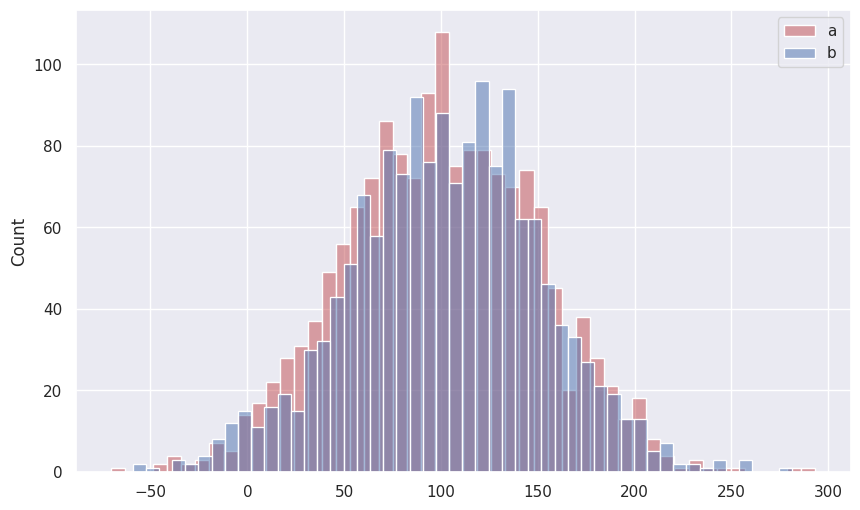

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(x=a, color="r", alpha=0.5, bins = 50)
sns.histplot(x=b, color="b", alpha=0.5, bins = 50)

plt.legend(labels=['a','b'])
plt.show()

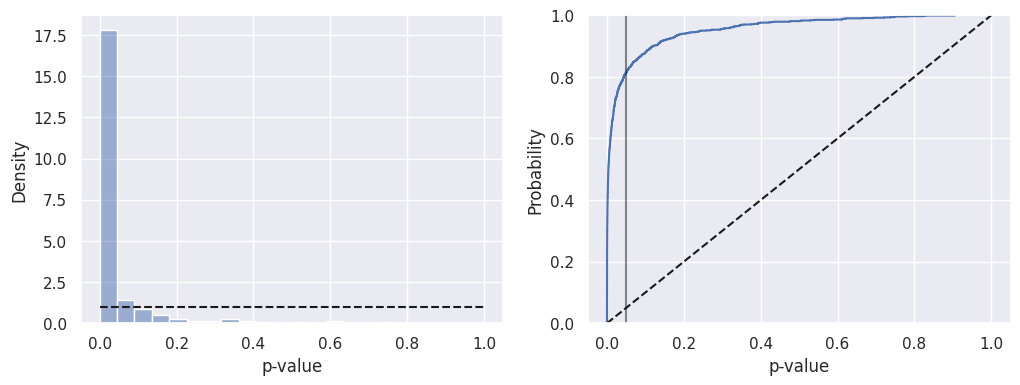

In [22]:
p_values = []
for _ in range(1000):
    a = np.random.normal(loc=mu,
                         scale=std,
                         size=sample_size)
    b = np.random.normal(loc=mu,
                         scale=std,
                         size=sample_size ) + 0.05*mu
    _, pvalue = ttest_ind(a, b)
    
    p_values.append(pvalue)
    
plot_hist_and_ecdf(p_values, add_vline=True)

При **наличии** эффекта мы должны контролировать вероятность ошибки 2-го рода, то есть
* на уровне значимости 0.0 мы должны ошибаться в среднем в 100 случаях из 100 (то есть всегда говорим, что отличий нет)
* на уровне значимости 0.05 мы должны ошибаться в среднем в 20 случаях из 100 
* на уровне значимости 1.0 мы должны ошибаться в среднем в 0 случаях из 100
(то есть всегда говорим, что отличия есть)

### Зависимые данные

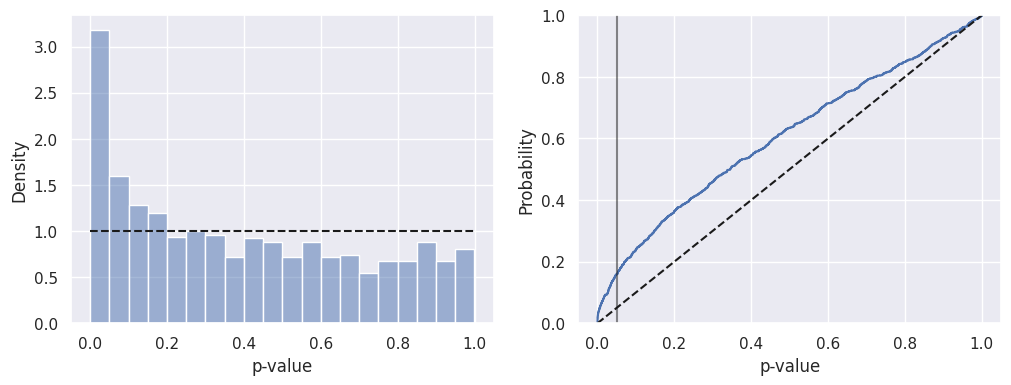

In [24]:
replication_factor = 2
p_values = []
for _ in range(1000):
    a_ = np.random.normal(loc=mu,
                         scale=std,
                         size=sample_size) 
    b_ = np.random.normal(loc=mu,
                         scale=std,
                         size=sample_size )
    a = np.concatenate([a_] * replication_factor)
    b = np.concatenate([b_] * replication_factor)
    _, pvalue = ttest_ind(a, b)
    
    p_values.append(pvalue)
    
plot_hist_and_ecdf(p_values, add_vline=True)    

$p-value$ распределено не равномерно. 
Такое поведения связано с тем, что выборка не удовлетворяет условиям регулярности t-test, в частности, наблюдения не независимы

## Дополнительные функции для генерации подвыборок

In [25]:
def create_group_generator(metrics, sample_size, n_iter):
    """Генератор случайных групп.

    :param metrics (pd.DataFame): таблица с метриками, columns=['user_id', 'metric'].
    :param sample_size (int): размер групп (количество пользователей в группе).
    :param n_iter (int): количество итераций генерирования случайных групп.
    :return (np.array, np.array): два массива со значениями метрик в группах.
    """
    user_ids = metrics['user_id'].unique()
    for _ in range(n_iter):
        a_user_ids, b_user_ids = np.random.choice(user_ids, (2, sample_size), False)
        a_metric_values = metrics.loc[metrics['user_id'].isin(a_user_ids), 'metric'].values
        b_metric_values = metrics.loc[metrics['user_id'].isin(b_user_ids), 'metric'].values
        yield a_metric_values, b_metric_values

def estimate_errors(group_generator, effect_add_type, effect, alpha):
    """Оценка вероятности ошибок I и II рода.

    :param group_generator: генератор значений метрик для двух групп.
    :param effect_add_type (str): способ добавления эффекта для группы B.
        - 'all_const' - увеличить всем значениям в группе B на константу (b_metric_values.mean() * effect / 100).
        - 'all_percent' - увеличить всем значениям в группе B в (1 + effect / 100) раз.
    :param effect (float): размер эффекта в процентах.
        Пример, effect=3 означает, что ожидаем увеличение среднего на 3%.
    :param alpha (float): уровень значимости.
    :return pvalues_aa (list[float]), pvalues_ab (list[float]), first_type_error (float), second_type_error (float):
        - pvalues_aa, pvalues_ab - списки со значениями pvalue
        - first_type_error, second_type_error - оценки вероятностей ошибок I и II рода.
    """
    pvalues_aa = []
    pvalues_ab = []
            
    for metrics_a_group, metrics_b_group in group_generator:
        pvalues_aa.append(ttest_ind(metrics_a_group, metrics_b_group).pvalue)
        if effect_add_type == 'all_const':
            metrics_b_group += (metrics_b_group.mean() * effect / 100)
            pvalues_ab.append(ttest_ind(metrics_a_group, metrics_b_group).pvalue)
        elif effect_add_type == 'all_percent':
            metrics_b_group *= (1 + effect / 100)
            pvalues_ab.append(ttest_ind(metrics_a_group, metrics_b_group).pvalue)
            
        first_type_error = np.mean(np.array(pvalues_aa) < alpha)
        second_type_error = np.mean(np.array(pvalues_ab) >= alpha)
            
    return pvalues_aa, pvalues_ab, first_type_error, second_type_error 

In [31]:
mu = 100
std = 50

user_id = [i for i in range(1, 10001)]
metric = np.random.normal(loc=mu, scale=std, size=10000)

general_df = pd.DataFrame({'user_id':user_id,
                            'metric': metric})
general_df.head()

,user_id,metric
0,1,86.534393
1,2,74.572116
2,3,175.589975
3,4,81.379604
4,5,129.752261


In [30]:
effect_add_type = 'all_const'
effect = 5
alpha = 0.05
sample_size = 1571

group_generator = create_group_generator(metrics=general_df, sample_size=sample_size, n_iter=10000)

pvalues_aa, pvalues_ab, first_type_error, second_type_error = estimate_errors(group_generator, effect_add_type, effect, alpha)

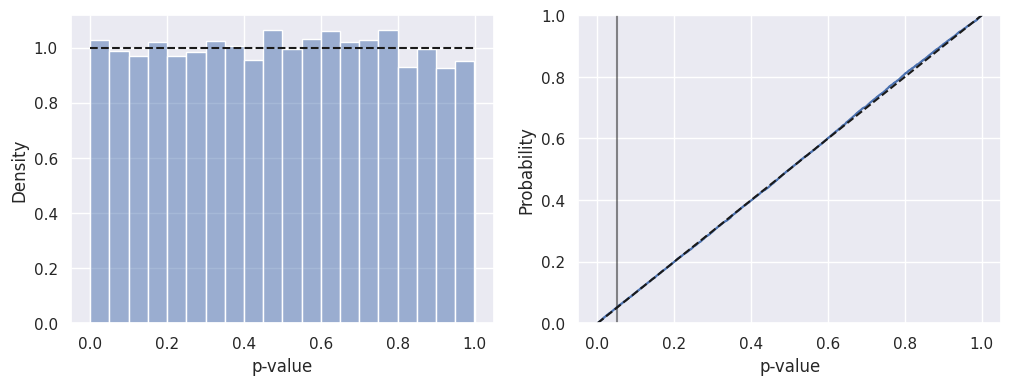

In [32]:
plot_hist_and_ecdf(pvalues_aa, add_vline=True)    

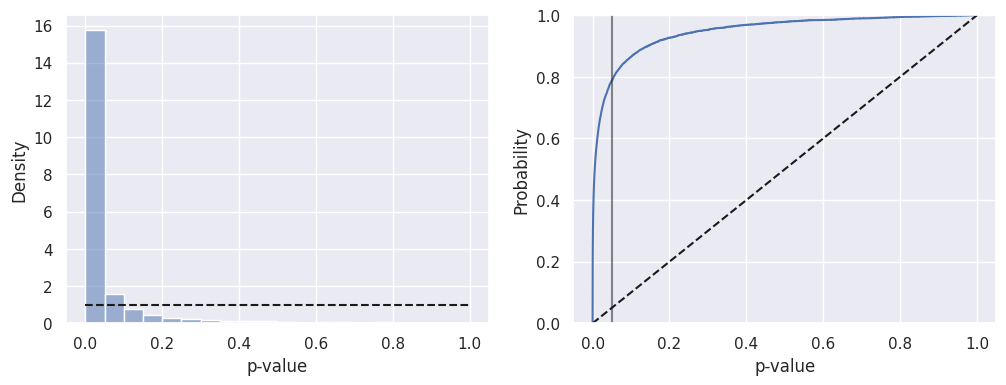

In [33]:
plot_hist_and_ecdf(pvalues_ab, add_vline=True) 